# The Sphinx model

Contact-map information such as Hi-C, Micro-C, Dilution Hi-C, and many others, are used to understand chromatin architecture. The [4D Nucleome project](https://data.4dnucleome.org/) has produced many such contact maps in various biosources, however there are still many missing experiments. Sphinx is a deep learning model built in PyTorch that can be used to impute missing experiments for unobserved experiments. This is a tutorial for training a new Sphinx model and making predictions for a celltype/assay combination using pretrained weights. The associated publication for Sphinx is

>Min, A., Schreiber, J., Kundaje, A., & Noble, W. S. (2024). Predicting chromatin conformation contact maps. bioRxiv. 

# Installing the conda environment

Sphinx is coded in Python using PyTorch, and the [source code](https://github.com/Noble-Lab/Sphinx/blob/main/Sphinx.py) is available for viewing.  [Conda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html) can be used to manage the dependencies for Sphinx. An environment [yaml file](https://github.com/Noble-Lab/Sphinx/blob/main/imputation.yml) is available and includes the packages that are required for Sphinx. To create an environment for Sphinx, you can use the following command to create a conda environment called "imputation" with all the requirements.

>conda env create -n imputation --file imputation.yml

# Using the Sphinx model to make predictions

We will start by demonstrating how to load in the pre-trained Sphinx weights and using the pre-trained weights to make predictions. 

In [2]:
# Import required packages for Sphinx
import numpy as np
import torch
import cooler as cooler
import pickle
import os
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import copy
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib
import Sphinx

print(f"Torch version is {torch.__version__}")
import sys
print(f"Python version is {sys.version}")
print(f"numpy version is {np.__version__}")

# Read in metadata
metadata_train = pd.read_csv("data/metadata_train.csv")
metadata_valid = pd.read_csv("data/metadata_valid.csv")
metadata_test = pd.read_csv("data/metadata_test.csv")

# Set parameters for the data
resolution = 100000
chromosome = '19'

# Scale the sum of log(x+1) of entries for each matrix to be 1e5
scale = 1e5

# Create the hicData matrix object
folder = "data/"
h = Sphinx.hicData(folder, metadata_train, metadata_valid, metadata_test, resolution, chromosome, scale, extension=".cool")

# Load the mean model using the hicData object
m = Sphinx.MeanModel(h)
mean_model_precomp = m.get_mean_model_dictionary()

Torch version is 2.0.1
Python version is 3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
numpy version is 1.25.2


/net/noble/vol1/home/alantmin/miniconda3/envs/imputation/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Observed Contact Map')

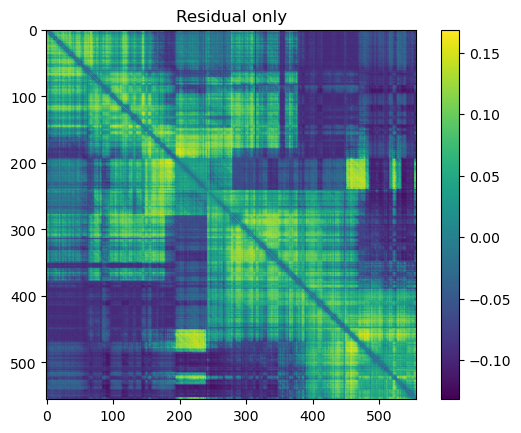

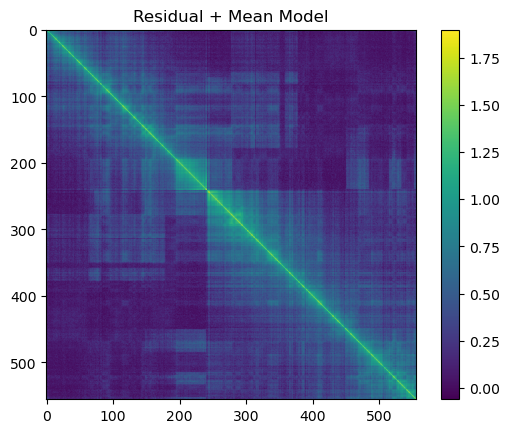

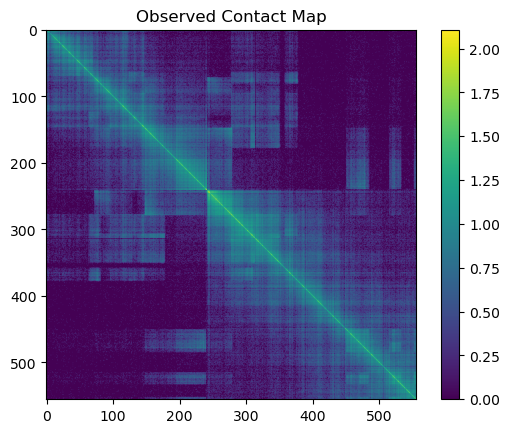

In [4]:
# These are the parameters for the model that was best from our hyperparameter search. 
data = h
residual = True
device = torch.device("cuda:0")
n_celltype_factor = 16
n_assay_factor = 128
n_position_factor = 128
n_distance_factor = 128
n_node = 256
n_layer = 4
dropout = 0.4

# Initialize the model
d = Sphinx.DeepMatrixFactorization(mean_model_precomp,
                    data,
                    device=device,
                    residual=residual,
                    n_celltype_factor=n_celltype_factor,
                    n_assay_factor=n_assay_factor,
                    n_position_factor=n_position_factor,
                    n_distance_factor=n_distance_factor,
                    n_node=n_node,
                    n_layer=n_layer,
                    debug=False,
                    dropout=dropout)

# Load the weights into the model and set the model to evaluation mode
d.load_state_dict(torch.load("sphinx_weights.pth"))
d.to(device)
d.eval()

# Make predictions for the celltype and assay 
celltype = metadata_train["Biosource"].iloc[0]
assay = metadata_train["Assay Type"].iloc[0]
plt.imshow(d.plot_matrix(celltype, assay).detach().cpu().numpy())
plt.colorbar()
plt.title("Residual only")

plt.figure()
mean_model = mean_model_precomp[(celltype, assay)]
plt.imshow(mean_model + d.plot_matrix(celltype, assay).detach().cpu().numpy())
plt.colorbar()
plt.title("Residual + Mean Model")

plt.figure()
plt.imshow(h.train_data[0].todense())
plt.colorbar()
plt.title("Observed Contact Map")

# Training your own model using the Sphinx Framework

We provide functions to train the Sphinx model using your own custom options and datasets. This is especially important as new data and new celltypes may be released which have the potential to improve predictions or expand the predictions that can be made. The Sphinx model takes...

In [11]:
# We assume that data has already been loaded as in the "Using the Sphinx model to make predictions" section

n_celltype_factor = 4
n_assay_factor = 4
n_position_factor = 5
n_node = 5
n_layer = 6
lr = 6
dropout = 0
print(f"Arguments were n_celltype_factor: {n_celltype_factor} n_assay_factor: {n_assay_factor} n_position_factor: {n_position_factor} n_node: {n_node} n_layer: {n_layer} lr: {lr} dropout: {dropout}")
batchsize=1000

torch.autograd.set_detect_anomaly(False)
m = Sphinx.MeanModel(h)
mean_model_precomp = m.get_mean_model_dictionary()
d = Sphinx.DeepMatrixFactorization(mean_model_precomp, h, device=device, residual=residual, n_celltype_factor=n_celltype_factor, n_assay_factor=n_assay_factor, n_position_factor=n_position_factor, n_distance_factor=n_position_factor, n_node=n_node, n_layer=n_layer, debug=False, dropout=dropout)
d.to(device)
optimizer = torch.optim.Adam(d.parameters(), lr=lr)
losses = d.fit(optimizer, None, max_epochs=2, batchsize=batchsize)
# pickle.dump(d, open(f"models/model_n_celltype_factor{n_celltype_factor}n_assay_factor{n_assay_factor}n_position_factor{n_position_factor}n_distance_factor{n_position_factor}n_node{n_node}n_layer{n_layer}dropout{dropout}lr{lr:.04f}.pickle", "wb"))
# pickle.dump(losses, open(f"models/losses_n_celltype_factor{n_celltype_factor}n_assay_factor{n_assay_factor}n_position_factor{n_position_factor}n_distance_factor{n_position_factor}n_node{n_node}n_layer{n_layer}dropout{dropout}lr{lr:.04f}.pickle", "wb"))

Arguments were n_celltype_factor: 4 n_assay_factor: 4 n_position_factor: 5 n_node: 5 n_layer: 6 lr: 6 dropout: 0
Epoch 0 took 53.746681213378906 seconds, valid_loss: -1.0, train_loss: 0.042349278926849365
Epoch 1 took 53.122074127197266 seconds, valid_loss: -1.0, train_loss: 0.048067376017570496


Text(0.5, 1.0, 'Observed Contact Map')

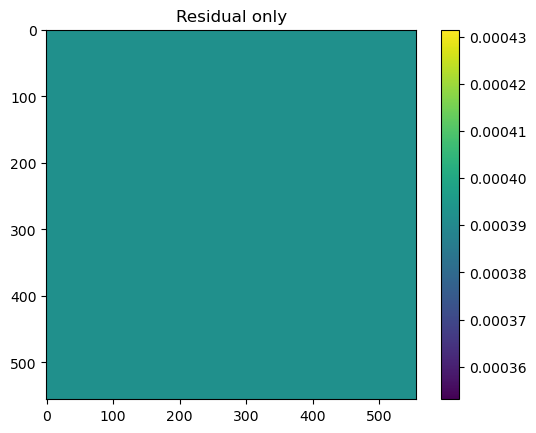

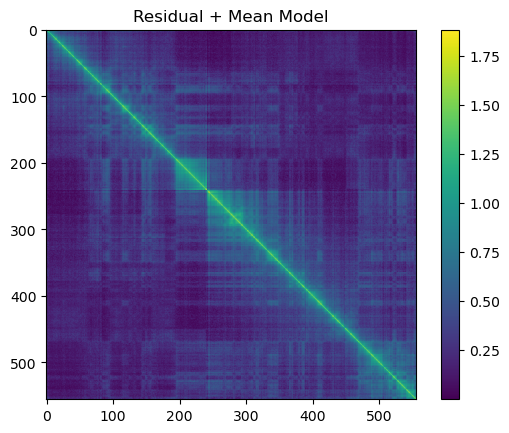

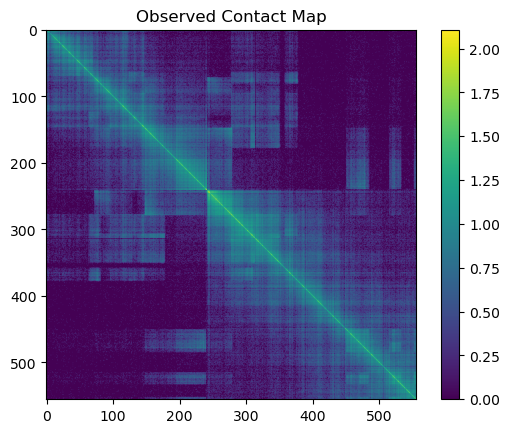

In [12]:
# Make predictions for the celltype and assay 
celltype = metadata_train["Biosource"].iloc[0]
assay = metadata_train["Assay Type"].iloc[0]
plt.imshow(d.plot_matrix(celltype, assay).detach().cpu().numpy())
plt.colorbar()
plt.title("Residual only")

plt.figure()
mean_model = mean_model_precomp[(celltype, assay)]
plt.imshow(mean_model + d.plot_matrix(celltype, assay).detach().cpu().numpy())
plt.colorbar()
plt.title("Residual + Mean Model")

plt.figure()
plt.imshow(h.train_data[0].todense())
plt.colorbar()
plt.title("Observed Contact Map")